# Balance Dataset

Given the dataset is unbalanced (much more malware than goodware), the classifier results may not be optimal. In this notebook we try to balance the dataset by applying the K-Means to the malware samples and selecting the samples closest to the centroids.

In [44]:
from IPython.display import display
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data_folder = '../data/'
final_dataset_file = data_folder + 'dataset_v1.csv.gz'
selected_imports_file = data_folder + 'selected_imports.csv.gz'
new_dataset_file = data_folder + 'dataset_v2.csv.gz'

cv_token_pattern = u'[^;]+'
vec_stop_words = ['*invalid*']
# Remove imports' extension
def token_preprocessor(s):
    return re.split('\..{0,3}', s)[0]

In [2]:
# Load dataset
dataset = pd.read_csv(final_dataset_file)
dataset = dataset.set_index('link')

# Load the selected features
features = pd.read_csv(selected_imports_file)
features = features['0'].values

In [50]:
cv = CountVectorizer(token_pattern=cv_token_pattern, stop_words=vec_stop_words,
                     preprocessor=token_preprocessor, vocabulary=featTures)
cv.fit(dataset.dlls)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function token_preprocessor at 0x7fef86d1e158>,
        stop_words=['*invalid*'], strip_accents=None,
        token_pattern='[^;]+', tokenizer=None,
        vocabulary=array(['steam_api', 'pshed', ..., 'vcl60', 'version'], dtype=object))

In [51]:
# The limit is given by the size of goodware samples
upper_limit = len(dataset[dataset.malware == 0])
malware = dataset[dataset.malware == 1]
malware_vectors = cv.transform(malware.dlls)

## K-Means

In [52]:
# Feature reduction

reduced_data = PCA(n_components=2).fit_transform(malware_vectors.toarray())
# Clustering
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=300, n_jobs=-1, max_iter=300)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=300, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

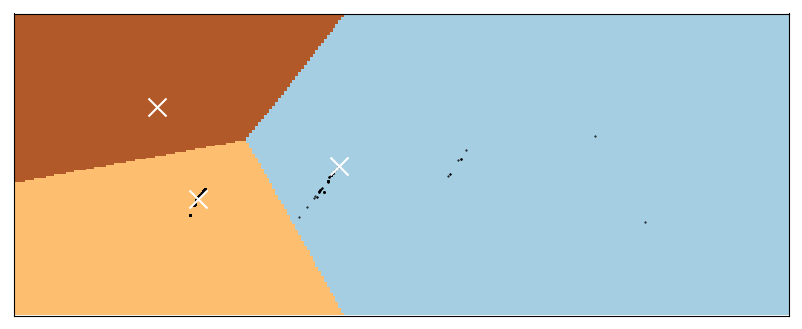

In [53]:
# Visualize K-Means

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 4), dpi=100)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=1)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [54]:
# Get roughly the same number of samples from each cluster
clustered_samples = kmeans.predict(reduced_data)
malware.is_copy = False
malware.loc[:,'cluster'] = clustered_samples

In [55]:
n_split = int(upper_limit/3)

new_dataset = malware[malware.cluster == 0][:n_split]
new_dataset = new_dataset.append(malware[malware.cluster == 1][:n_split])
new_dataset = new_dataset.append(malware[malware.cluster == 2][:n_split])
new_dataset.drop('cluster', axis=1, inplace=True)
new_dataset = new_dataset.append(dataset[dataset.malware == 0])

In [56]:
new_dataset.to_csv(new_dataset_file, compression='gzip')